# 导入包

In [7]:
import torch
import numpy as np
import random
from torch.utils.data import  Dataset
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 全局变量

In [8]:
batch_size=512
lr  = 0.01
epoch_num = 15
num_workers=0

# 构造数据集

In [9]:
random.seed(42)
torch.manual_seed(42)
class MultiDataSet(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.mnist = torchvision.datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.targets = torch.eye(10)[self.mnist.targets]

    def __getitem__(self, index):
        image, target = self.mnist[index]
        processed_target = self.targets[index]
        return image, processed_target, target

    def __len__(self):
        return len(self.mnist)

mnist_train = MultiDataSet(root='E:/毕设文件/DeepLearning/experiment01/Datasets/MNIST', train=True,
                                    download=True, transform=transforms.ToTensor())
mnist_test = MultiDataSet(root='E:/毕设文件/DeepLearning/experiment01/Datasets/MNIST', train=False,
                                   download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=num_workers)

# 定义激活函数 定义网络结构 定义网络初始化参数

In [10]:
inputs = 784
hiddens = 256
out = 10
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(inputs,hiddens)
        self.relu = torch.nn.ReLU()
        self.hidden = torch.nn.Linear(hiddens,out)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        t = self.linear(x)
        t = self.relu(t)
        t = self.hidden(t)
        t = self.softmax (t)
        return  t


loss =  torch.nn.CrossEntropyLoss()


# 定义Adam优化器类

In [11]:
class AdamOptimizer:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {param: torch.zeros_like(param) for param in self.parameters}
        self.v = {param: torch.zeros_like(param) for param in self.parameters}
        self.t = 0

    def step(self):
        self.t += 1
        for param in self.parameters:
            grad = param.grad
            self.m[param] = self.beta1 * self.m[param] + (1 - self.beta1) * grad
            self.v[param] = self.beta2 * self.v[param] + (1 - self.beta2) * grad ** 2
            m_hat = self.m[param] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param] / (1 - self.beta2 ** self.t)
            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)
            param.grad.zero_()

# 训练评估模型-Adam优化器

In [12]:
import time

train_loss_0 =[]
test_loss_0 = []
train_acc_0=[]
test_acc_0= []
start_time = time.time()
net0 = Net().to(device)
opt0 = AdamOptimizer(parameters=net0.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:

        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net0(x.to(device))
        l = loss(y_hat,y.to(device))
        l.backward()
        opt0.step()
        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_0.append(train_loss_mean)
    train_acc_0.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net0(x.to(device))
        l = loss(y_hat,y.to(device))
        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_0.append(test_loss_mean)
    test_acc_0.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 1.5935135509213831 train_acc: 0.8746828258547008 
 test_loss: 1.530925844845019 test_acc: 0.9317434210526315
epoch: 2 
 train_loss: 1.5150755704977574 train_acc: 0.947532719017094 
 test_loss: 1.5024706501709788 test_acc: 0.958984375
epoch: 3 
 train_loss: 1.4983190848277166 train_acc: 0.9637920673076923 
 test_loss: 1.497044745244478 test_acc: 0.9646381578947368
epoch: 4 
 train_loss: 1.4927380258201535 train_acc: 0.9697516025641025 
 test_loss: 1.4936375367014032 test_acc: 0.9686472039473685
epoch: 5 
 train_loss: 1.4879278810615213 train_acc: 0.9740584935897436 
 test_loss: 1.4903189069346379 test_acc: 0.9708059210526315
epoch: 6 
 train_loss: 1.4860801014125857 train_acc: 0.9755275106837606 
 test_loss: 1.4883110899674266 test_acc: 0.9728618421052632
epoch: 7 
 train_loss: 1.4833423816240752 train_acc: 0.9780815972222222 
 test_loss: 1.4869722065172697 test_acc: 0.9748149671052632
epoch: 8 
 train_loss: 1.4816349887440348 train_acc: 0.9800180288461539 
 test_

# Momentum算法手动实现

In [13]:
class MomentumOptimizer:
    def __init__(self, parameters, lr=0.001, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocity = {param: torch.zeros_like(param) for param in self.parameters}

    def step(self):
        for param in self.parameters:
            grad = param.grad
            self.velocity[param] = self.momentum * self.velocity[param] - self.lr * grad
            param.data += self.velocity[param]

            # 清零梯度
            param.grad.zero_()

# 训练评估模型-Momentum优化器

In [14]:
import time
train_loss_1 =[]
test_loss_1 = []
train_acc_1=[]
test_acc_1= []
start_time = time.time()
net1 = Net().to(device)
opt1 = MomentumOptimizer(parameters=net1.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net1(x.to(device))
        l = loss(y_hat,y.to(device))
        l.backward()
        opt1.step()

        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_1.append(train_loss_mean)
    train_acc_1.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net1(x.to(device))
        l = loss(y_hat,y.to(device))
        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_1.append(test_loss_mean)
    test_acc_1.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 2.291353402993618 train_acc: 0.3314135950854701 
 test_loss: 2.269350240105077 test_acc: 0.4095394736842105
epoch: 2 
 train_loss: 2.2013386335128393 train_acc: 0.36847288995726496 
 test_loss: 2.0977893252121773 test_acc: 0.4349300986842105
epoch: 3 
 train_loss: 1.9950285426571839 train_acc: 0.5590444711538461 
 test_loss: 1.8908578910325702 test_acc: 0.6953125
epoch: 4 
 train_loss: 1.8323173859180548 train_acc: 0.7304186698717948 
 test_loss: 1.7645881677928723 test_acc: 0.794202302631579
epoch: 5 
 train_loss: 1.7414914665059147 train_acc: 0.7950721153846154 
 test_loss: 1.7070249946493852 test_acc: 0.8148643092105263
epoch: 6 
 train_loss: 1.701983232783456 train_acc: 0.8106470352564102 
 test_loss: 1.6801507410250212 test_acc: 0.825452302631579
epoch: 7 
 train_loss: 1.6817203434104593 train_acc: 0.8179420405982906 
 test_loss: 1.6651456481532048 test_acc: 0.8312088815789473
epoch: 8 
 train_loss: 1.6693133767853436 train_acc: 0.8234007745726496 
 test_los

# rmsprop优化器手动实现

In [15]:
class RMSpropOptimizer:
    def __init__(self, parameters, lr=0.001, beta=0.99, epsilon=1e-03):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.squared_gradients = {param: torch.zeros_like(param) for param in self.parameters}

    def step(self):
        for param in self.parameters:
            grad = param.grad
            self.squared_gradients[param] = self.beta * self.squared_gradients[param] + (1 - self.beta) * grad ** 2
            rms = torch.sqrt(self.squared_gradients[param] + self.epsilon)
            param.data -= self.lr * grad / rms

            # 清零梯度
            param.grad.zero_()


# 训练评估模型-rmsprop优化器

In [16]:
import time

train_loss_2 =[]
test_loss_2 = []
train_acc_2=[]
test_acc_2= []
start_time = time.time()
net2 = Net().to(device)
opt2 = RMSpropOptimizer(parameters=net2.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net2(x.to(device))
        l = loss(y_hat,y.to(device))
        l.backward()
        opt2.step()
        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_2.append(train_loss_mean)
    train_acc_2.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net2(x.to(device))
        l = loss(y_hat,y.to(device))

        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_2.append(test_loss_mean)
    test_acc_2.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 2.1173265469379916 train_acc: 0.4506043002136752 
 test_loss: 1.8204016560002376 test_acc: 0.7241981907894737
epoch: 2 
 train_loss: 1.7638887350375836 train_acc: 0.7378806089743589 
 test_loss: 1.7025495955818577 test_acc: 0.82421875
epoch: 3 
 train_loss: 1.6801351227312007 train_acc: 0.8211638621794872 
 test_loss: 1.6512804345080727 test_acc: 0.8383018092105263
epoch: 4 
 train_loss: 1.6518144199990819 train_acc: 0.8314135950854701 
 test_loss: 1.636408153333162 test_acc: 0.8422080592105263
epoch: 5 
 train_loss: 1.6403904114014063 train_acc: 0.8366052350427351 
 test_loss: 1.62900615993299 test_acc: 0.8448807565789473
epoch: 6 
 train_loss: 1.6335307186485355 train_acc: 0.8404780982905983 
 test_loss: 1.6240124326003225 test_acc: 0.8485814144736842
epoch: 7 
 train_loss: 1.6283604772681863 train_acc: 0.8433660523504274 
 test_loss: 1.6180545279854222 test_acc: 0.8523848684210527
epoch: 8 
 train_loss: 1.5928296350006363 train_acc: 0.890357905982906 
 test_lo

# 结果评估与图形可视化
- Momentum 运行352秒
- Adam 运行332秒
- rmsprop 运行298.81秒
不同优化器对模型的性能产生了影响。在这个特定任务中，Adam优化器表现得较好，达到了最高的准确率。RMSprop优化器次之，而Momentum优化器表现相对较差。

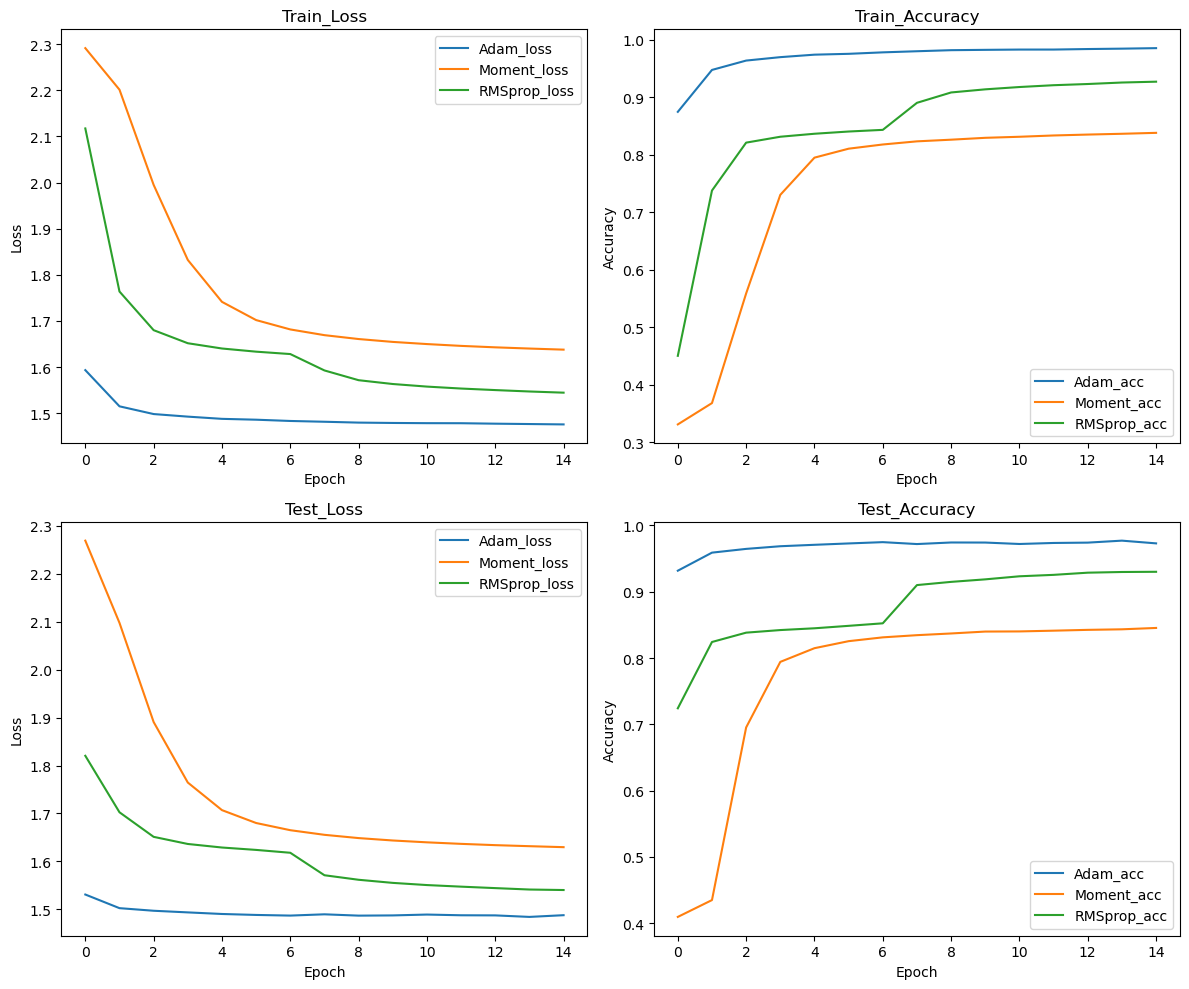

In [17]:
# 示例数据
train_loss = [train_loss_0, train_loss_1, train_loss_2]
test_loss = [test_loss_0, test_loss_1, test_loss_2]
train_acc = [train_acc_0, train_acc_1, train_acc_2]
test_acc = [test_acc_0, test_acc_1, test_acc_2]
titles_loss = ['Train_Loss', 'Test_Loss']
titles_acc = ['Train_Accuracy', 'Test_Accuracy']
labels = ['Adam', 'Moment', 'RMSprop']

# 创建2x2的图，并添加脚标
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 绘制Train_Loss和Test_Loss
for i in range(3):
    ax_train_loss = axes[0, 0]
    ax_train_loss.plot(train_loss[i], label=f'{labels[i]}_loss')

    ax_test_loss = axes[1, 0]
    ax_test_loss.plot(test_loss[i], label=f'{labels[i]}_loss')

# 绘制Train_Accuracy和Test_Accuracy
for i in range(3):
    ax_train_acc = axes[0, 1]
    ax_train_acc.plot(train_acc[i], label=f'{labels[i]}_acc')

    ax_test_acc = axes[1, 1]
    ax_test_acc.plot(test_acc[i], label=f'{labels[i]}_acc')

# 设置标题和标签
for ax in axes.flat:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if ax in [axes[0, 0], axes[1, 0]] else 'Accuracy')

axes[0, 0].set_title(titles_loss[0])
axes[0, 0].legend()

axes[1, 0].set_title(titles_loss[1])
axes[1, 0].legend()

axes[0, 1].set_title(titles_acc[0])
axes[0, 1].legend()

axes[1, 1].set_title(titles_acc[1])
axes[1, 1].legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
